In [1]:
import sys
sys.path.insert(0, "../..")
#%reload_ext autoreload
#%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
import numpy
import math
import spatialpy
print(spatialpy.__file__)

../../spatialpy/__init__.py


In [3]:
class Membrane(spatialpy.Geometry):
    def __init__(self, radius_external, radius_internal):
        spatialpy.Geometry.__init__(self)
        self.radius_external = radius_external
        self.radius_internal = radius_internal
        
    def inside(self, x, on_boundary):
        r = numpy.sqrt(x[0] * x[0] + x[1] * x[1])
        return self.radius_external >= r >= self.radius_internal
    
class Cytoplasm(spatialpy.Geometry):
    def __init__(self, radius_external, radius_internal):
        spatialpy.Geometry.__init__(self)
        self.radius_external = radius_external
        self.radius_internal = radius_internal
        
    def inside(self, x, on_boundary):
        r = numpy.sqrt(x[0] * x[0] + x[1] * x[1])
        return r < self.radius_internal
    
class GbgGradient(spatialpy.DataFunction):
    def __init__(self, Gbg_mid=5000, Gbg_slope=0.0, mem_vol=1.0):
        """ 1D domain from a to b. """
        spatialpy.DataFunction.__init__(self, name="GbgGradient")
        self.Gbg_mid = Gbg_mid
        self.Gbg_slope = Gbg_slope  # NM/um
        self.mem_vol = mem_vol
        
    def expression(self):
        return '({0}*me->x[1] + {1})/{2}'.format(
            self.Gbg_slope,self.Gbg_mid,self.mem_vol)

In [18]:
class Cdc42_cycle_2D_SpatialPy_SDPD(spatialpy.Model):

    def __init__(self, model_name="Cdc42_2D",
                 end_time=None, DX=10):
        spatialpy.Model.__init__(self,model_name)

        #################################################
        Gbg_conc=5000.0
        Gbg_pct_slope=0.0
        delta1_val=0.00297
        delta1_gbg_val=0.00297
        delta_neg_val=1.0/30000
        #################################################
        radius_external = 0.6
        radius_internal = 0.4
        

        self.domain = spatialpy.Domain.create_2D_domain(
            xlim=[-1,1],
            ylim=[-1,1],
            nx=DX,
            ny=DX,
            rho0=1.0,
            c0=10,
            P0=10,
        )

        self.set_type(Membrane(radius_external, radius_internal), 2, mass=4.0, nu=1.0, fixed=False)
        self.set_type(Cytoplasm(radius_external, radius_internal), 3, mass=2.0, nu=1.0, fixed=False)

        #################################################
        extra_cellular_volume = 0
        extra_cellular_count = 0
        for voxel_index, voxel_coords in enumerate(self.domain.coordinates()):
                if self.domain.type[voxel_index] == 1:
                    extra_cellular_volume = extra_cellular_volume + self.domain.vol[voxel_index]
                    extra_cellular_count+=1
                    
        membrane_volume = 0#0.15
        membrane_count = 0
        for voxel_index, voxel_coords in enumerate(self.domain.coordinates()):
                if self.domain.type[voxel_index] == 2:
                    membrane_volume = membrane_volume + self.domain.vol[voxel_index]
                    membrane_count+=1
                    
        cytoplasm_volume = 0#0.02
        cytoplasm_count = 0
        for voxel_index, voxel_coords in enumerate(self.domain.coordinates()):
                if self.domain.type[voxel_index] == 3:
                    cytoplasm_volume = cytoplasm_volume + self.domain.vol[voxel_index]
                    cytoplasm_count+=1
                    
        true_cytoplasm_volume = math.pi*radius_internal*radius_internal
        true_membrane_volume = math.pi*radius_external*radius_external - true_cytoplasm_volume
        membrane_error = abs(true_membrane_volume-membrane_volume)/true_membrane_volume*100
        cytoplasm_error = abs(true_cytoplasm_volume-cytoplasm_volume)/true_cytoplasm_volume*100
        
        print("Volumes:  DX={}".format(DX))
        print("\textracellular\t{0} ({1} paticles)".format(
            extra_cellular_volume,extra_cellular_count))
        print("\tmembrane\t{} ({} paticles)\t{:.2f}% error".format(membrane_volume,membrane_count,membrane_error))
        print("\tcytoplasm\t{} ({} paticles)\t{:.2f}% error".format(cytoplasm_volume,cytoplasm_count,cytoplasm_error))
        #################################################
        
        D_membrane = 0.0053   #diffusion on the membrane from PLOS paper
        D_GDP = 0.0053
        D_GTP = 0.0053
        D_bulk = 10.0
        
        # Species
        Cdc24_m = spatialpy.Species(name="Cdc24_m",  diffusion_constant=D_membrane)
        Cdc24_c = spatialpy.Species(name="Cdc24_c",  diffusion_constant=D_bulk)
        Cdc42   = spatialpy.Species(name="Cdc42",    diffusion_constant=D_GDP)
        Cdc42_a = spatialpy.Species(name="Cdc42_a",  diffusion_constant=D_GTP)
        Bem1_m  = spatialpy.Species(name="Bem1_m",   diffusion_constant=D_membrane)
        Bem1_c  = spatialpy.Species(name="Bem1_c",   diffusion_constant=D_bulk)
        Cla4    = spatialpy.Species(name="Cla4",     diffusion_constant=D_bulk)
        Cla4_a  = spatialpy.Species(name="Cla4_a",   diffusion_constant=D_membrane)
        Cdc42_c = spatialpy.Species(name="Cdc42_c",  diffusion_constant=D_bulk)
        self.add_species([Cdc24_m, Cdc24_c, Cdc42, Cdc42_a, Bem1_m, Bem1_c, Cla4, Cla4_a, Cdc42_c])

        #################################################
        # Parameters
        k_42d =   spatialpy.Parameter(name="k_42d", expression=1.0)
        k_42a =   spatialpy.Parameter(name="k_42a", expression=0.2)
        k_24cm1 = spatialpy.Parameter(name="k_24cm1", expression=delta1_val)
        k_24mc =  spatialpy.Parameter(name="k_24mc", expression=0.35) 
        k_B1mc =  spatialpy.Parameter(name="k_B1mc", expression=0.35)
        k_B1cm =  spatialpy.Parameter(name="k_B1cm", expression=0.2667)
        k_Cla4a = spatialpy.Parameter(name="k_Cla4a", expression=0.006)
        k_Cla4d = spatialpy.Parameter(name="k_Cla4d", expression=0.01)
        k_24d =   spatialpy.Parameter(name="k_24d", expression=delta_neg_val)

        beta1 = spatialpy.Parameter(name="beta1", expression=0.266) 
        beta2 = spatialpy.Parameter(name="beta2", expression=0.28)
        beta3 = spatialpy.Parameter(name="beta3", expression=1.0) 
        delta1_gbg = spatialpy.Parameter(name="delta1_gbg", expression=delta1_gbg_val)
        self.add_parameter([k_42a, k_42d, k_24cm1, k_24mc, k_B1mc, k_B1cm, k_Cla4a, k_Cla4d, k_24d,beta1, beta2, beta3,delta1_gbg])

        # Add Data Function to model the mating pheromone gradient.
        self.add_data_function(GbgGradient(
                Gbg_mid=Gbg_conc,
                Gbg_slope=Gbg_conc*Gbg_pct_slope/(radius_external*2.0),
                mem_vol=membrane_volume
            ))

        # Reactions
        CR0 = spatialpy.Reaction(name="CR0", reactants={Cdc24_c:1}, products={Cdc24_m:1}, propensity_function="delta1_gbg*Cdc24_c*GbgGradient*vol", restrict_to=2)
        CR1 = spatialpy.Reaction(name="CR1", reactants={Cdc24_c:1,Bem1_m:1}, products={Cdc24_m:1,Bem1_m:1},  rate=k_24cm1, restrict_to=2)
        CR2 = spatialpy.Reaction(name="CR2", reactants={Cdc24_m:1}, products={Cdc24_c:1}, rate=k_24mc, restrict_to=2)
        CR3 = spatialpy.Reaction(name="CR3", reactants={Cdc24_m:1,Cla4_a:1}, products={Cdc24_c:1,Cla4_a:1}, rate=k_24d, restrict_to=2)
        CR4 = spatialpy.Reaction(name="CR4", reactants={Cdc24_m:1,Cdc42:1}, products={Cdc24_m:1,Cdc42_a:1}, rate=k_42a, restrict_to=2)
        CR5 = spatialpy.Reaction(name="CR5", reactants={Cdc42_a:1}, products={Cdc42:1}, rate=k_42d, restrict_to=2)
        CR6 = spatialpy.Reaction(name="CR6", reactants={Cdc42_a:1,Bem1_c:1}, products={Cdc42_a:1,Bem1_m:1}, rate=k_B1cm, restrict_to=2)
        CR7 = spatialpy.Reaction(name="CR7", reactants={Bem1_m:1}, products={Bem1_c:1}, rate=k_B1mc, restrict_to=2)
        CR8 = spatialpy.Reaction(name="CR8", reactants={Cdc42_a:1,Cla4:1}, products={Cdc42_a:1,Cla4_a:1}, rate=k_Cla4a, restrict_to=2)
        CR9 = spatialpy.Reaction(name="CR9", reactants={Cla4_a:1}, products={Cla4:1}, rate=k_Cla4d, restrict_to=2)
        
        CR10 = spatialpy.Reaction(name="CR10", reactants={Cdc42_c:1}, products={Cdc42:1}, rate=beta2, restrict_to=2)
        CR11 = spatialpy.Reaction(name="CR11", reactants={Cdc42:1}, products={Cdc42_c:1}, rate=beta3, restrict_to=2)
        CR12 = spatialpy.Reaction(name="CR12", reactants={Cdc42_c:1,Cdc24_m:1}, products={Cdc42_a:1,Cdc24_m:1}, rate=beta1, restrict_to=2)
        self.add_reaction([CR0,CR1,CR2,CR3,CR4,CR5,CR6,CR7,CR8,CR9,CR10,CR11,CR12])
        
        self.restrict(species=Cdc24_c,listOfTypes=[3,2])
        self.restrict(species=Bem1_c,listOfTypes=[3,2])
        self.restrict(species=Cla4,listOfTypes=[3,2])
        self.restrict(species=Cdc24_m,listOfTypes=[2])
        self.restrict(species=Cdc42,listOfTypes=[2])
        self.restrict(species=Cdc42_a,listOfTypes=[2])
        self.restrict(species=Bem1_m,listOfTypes=[2])
        self.restrict(species=Cla4_a,listOfTypes=[2])
        self.restrict(species=Cdc42_c,listOfTypes=[3,2])
        
        # Scatter initial condition
        self.add_initial_condition(spatialpy.ScatterInitialCondition(Cdc42,2700,[3])) # 10000  
        self.add_initial_condition(spatialpy.ScatterInitialCondition(Cdc24_c,1000,[2])) # We have 2000 Cdc24, GDI model has 1000
        self.add_initial_condition(spatialpy.ScatterInitialCondition(Bem1_c,3000,[2]))
        self.add_initial_condition(spatialpy.ScatterInitialCondition(Cla4,5000,[2]))  # 5000
        self.add_initial_condition(spatialpy.ScatterInitialCondition(Cdc42_a,300,[3]))

        # Do not allow points to move
        self.staticDomain = True

        # Set timestep
        self.timestep_size = 1
        
        if end_time is None:
            self.timespan(range(1000))
        else:
            if end_time >= 1.0:
                self.timespan(range(end_time))
            else:
                self.timespan(numpy.linspace(0,end_time,10))
            print("simulating to {0}s".format(end_time))

In [19]:
for dx in range(10,100,10):
    model = Cdc42_cycle_2D_SpatialPy_SDPD(DX=dx)

Volumes:  DX=10
	extracellular	3.040000000000002 (76 paticles)
	membrane	0.4799999999999999 (12 paticles)	23.61% error
	cytoplasm	0.4799999999999999 (12 paticles)	4.51% error
Volumes:  DX=20
	extracellular	3.039999999999979 (304 paticles)
	membrane	0.5200000000000002 (52 paticles)	17.24% error
	cytoplasm	0.4400000000000002 (44 paticles)	12.46% error
Volumes:  DX=30
	extracellular	2.9333333333333007 (660 paticles)
	membrane	0.5688888888888879 (128 paticles)	9.46% error
	cytoplasm	0.4977777777777763 (112 paticles)	0.97% error
Volumes:  DX=40
	extracellular	2.919999999999949 (1168 paticles)
	membrane	0.5999999999999982 (240 paticles)	4.51% error
	cytoplasm	0.48000000000000037 (192 paticles)	4.51% error
Volumes:  DX=50
	extracellular	2.9119999999999404 (1820 paticles)
	membrane	0.608000000000001 (380 paticles)	3.23% error
	cytoplasm	0.479999999999998 (300 paticles)	4.51% error
Volumes:  DX=60
	extracellular	2.9022222222222998 (2612 paticles)
	membrane	0.6088888888888861 (548 paticles)	3.09

In [14]:
model = Cdc42_cycle_2D_SpatialPy_SDPD(end_time=100)

Volumes:  DX=10
	extracellular	3.040000000000002 (76 paticles)
	membrane	0.4799999999999999 (12 paticles)	23.61% error
	cytoplasm	0.4799999999999999 (12 paticles)	4.51% error
simulating to 100s


In [15]:
%time result = model.run(debug_level=0)

CPU times: user 176 ms, sys: 12 ms, total: 188 ms
Wall time: 46.9 s


In [16]:
Cdc42_vals = result.get_species("Cdc42_a", debug=False)

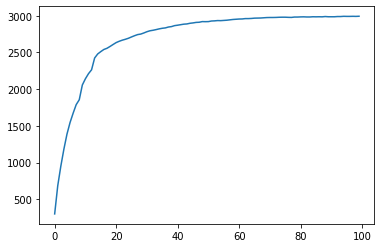

In [17]:
plt.plot(result.get_timespan(), Cdc42_vals.sum(axis=1))

In [9]:
#result.display("Cdc42_a",0)

In [10]:
type_vals = result.get_property("type",0)

In [11]:
Cdc42_a_results = result.get_species("Cdc42_a", deterministic=True, debug=False)
print(numpy.amax(Cdc42_a_results))

nan


In [20]:
def plot_step(t_ndx,key='type'):
    pts, data = result.read_step(t_ndx)
    plt.figure(figsize=(15,10) )
    plt.scatter(pts[:,0],pts[:,1],c=data[key])
    plt.axis('equal')
    plt.colorbar()
    plt.title('t={0}'.format(t_ndx))
    
def plot_all(key='type'):
    for i,t in enumerate(result.get_timespan()):
        if (i % 10) == 0:
            plot_step(i,key)


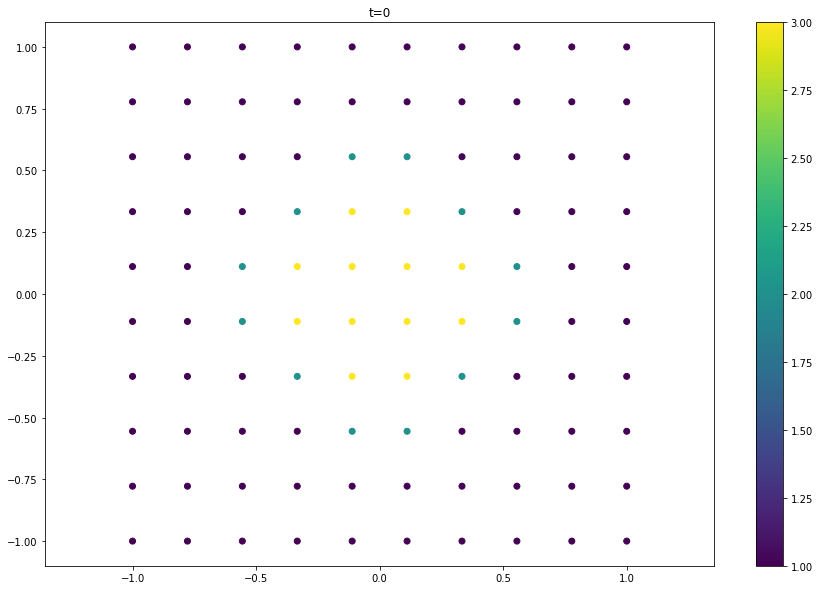

In [21]:
plot_step(0, key='type')

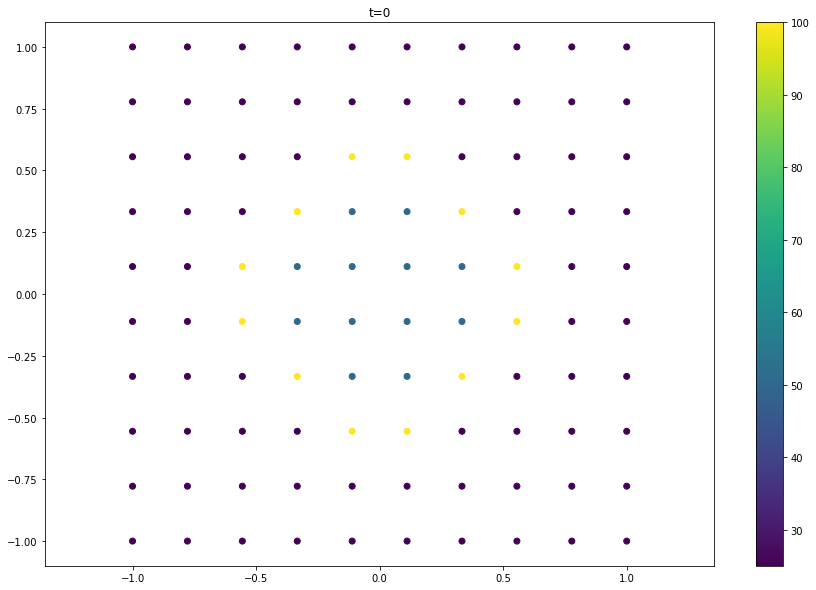

In [22]:
plot_step(0, key="rho")

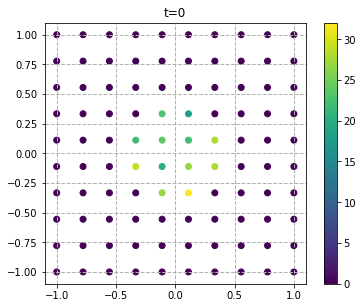

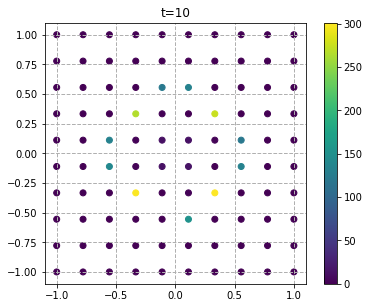

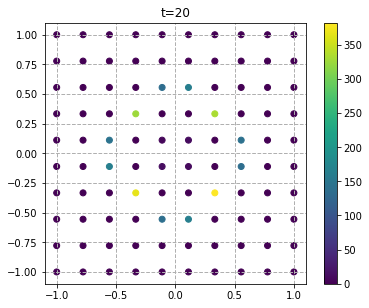

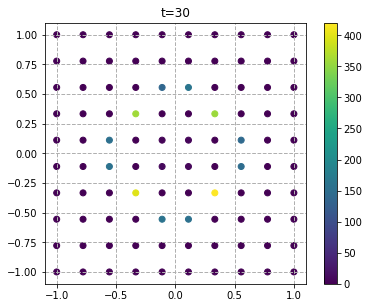

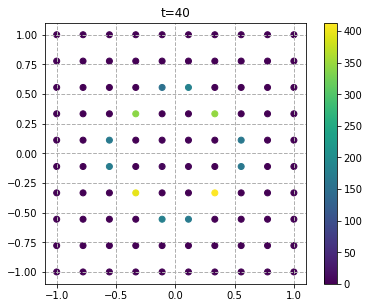

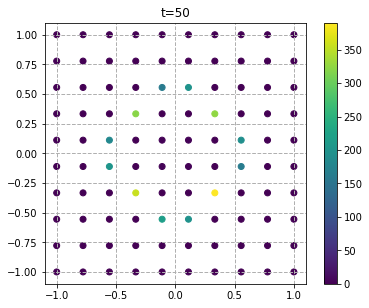

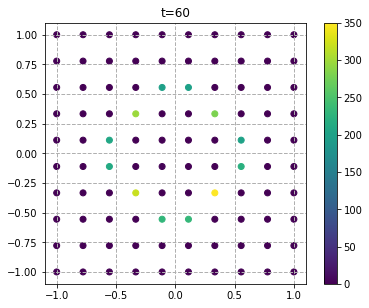

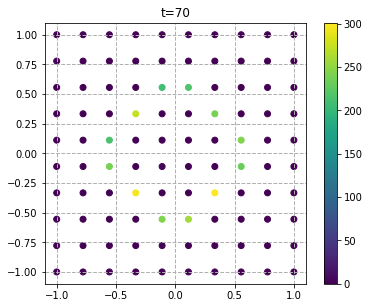

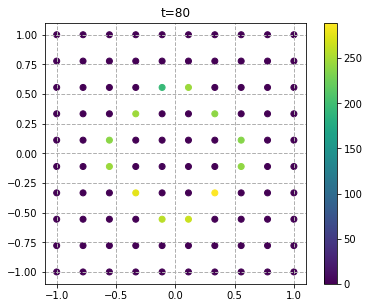

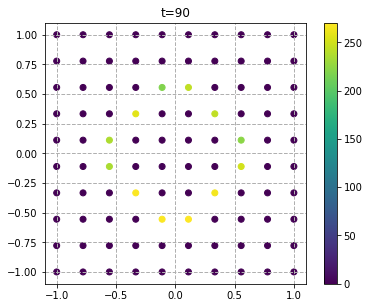

In [23]:
for i,t in enumerate(result.get_timespan()):
    if (i % 10) == 0:
        result.plot_species("Cdc42_a", i, title="t=" + str(i), use_matplotlib=True)